# Machine Learning Project

## Imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import pathlib
import PIL
import os
import time
import sklearn.preprocessing
from datetime import datetime
from packaging import version

import matplotlib.pyplot as plt
import matplotlib
#set fonts to display labels correctly
matplotlib.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'MS Gothic'
    }
)


## Check GPUs

In [2]:
print("GPUs Available: ", tf.test.gpu_device_name())

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.keras.mixed_precision.set_global_policy("mixed_float16")

GPUs Available:  /device:GPU:0
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2070 SUPER, compute capability 7.5


In [3]:
tf.config.threading.set_inter_op_parallelism_threads(64)
tf.config.threading.set_intra_op_parallelism_threads(64)

print(tf.config.threading.get_inter_op_parallelism_threads())
print(tf.config.threading.get_intra_op_parallelism_threads())

64
64


## Load Data

Data stored as 201 images per character, each character's images are grouped in folders labelled with the character.

In [4]:

data_dir = pathlib.Path('Data/subset/')
#data_dir = pathlib.Path('Data/characters/')


image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

low = list(data_dir.glob('低/*'))
for i in range(9):
    PIL.Image.open(str(low[i]))

40200


In [5]:
batch_size = 16
img_height = 64
img_width = 64
epochs = 50

In [6]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != 'LICENSE.txt']))
print(class_names)

['一' '丁' '七' '万' '丈' '三' '上' '下' '不' '与' '丑' '且' '世' '丘' '丙' '丞' '両' '並'
 '中' '串' '丸' '丹' '主' '乃' '久' '之' '乍' '乎' '乏' '乗' '乙' '九' '乞' '也' '乱' '乳'
 '乾' '亀' '了' '予' '争' '事' '二' '云' '互' '五' '井' '亘' '亙' '些' '亜' '亡' '交' '亥'
 '亦' '亨' '享' '京' '亭' '亮' '人' '什' '仁' '仇' '今' '介' '仏' '仔' '仕' '他' '付' '仙'
 '代' '令' '以' '仮' '仰' '仲' '件' '任' '企' '伊' '伍' '伎' '伏' '伐' '休' '会' '伝' '伯'
 '伴' '伶' '伸' '伺' '似' '伽' '佃' '但' '位' '低' '住' '佐' '佑' '体' '何' '余' '作' '佳'
 '併' '佼' '使' '侃' '例' '侍' '供' '依' '侠' '価' '侭' '侮' '侯' '侵' '侶' '便' '係' '促'
 '俄' '俊' '俗' '保' '信' '俣' '修' '俳' '俵' '俸' '俺' '倉' '個' '倍' '倒' '倖' '候' '借'
 '倣' '値' '倦' '倫' '倭' '倶' '倹' '偉' '偏' '停' '健' '偲' '側' '偵' '偶' '偽' '傍' '傑'
 '傘' '備' '催' '傭' '債' '傷' '傾' '僅' '働' '像' '僑' '僕' '僚' '僧' '僻' '儀' '億' '儒'
 '償' '優' '儲' '允' '元' '兄' '充' '兆' '兇' '先' '光' '克' '免' '兎' '児' '党' '兜' '入'
 '全' '八']


In [7]:
data = {}
data['data'] = []
data['label'] = []

i = 0
last = None
for item in data_dir.glob('*'):
    for pic in data_dir.glob(f'{item.name}/*'):
        data['data'].append(np.asarray(PIL.Image.open(pic).resize((64, 64))))
        data['label'].append(item.name)


data['data'] = np.asarray(data['data'])


In [8]:
enc = sklearn.preprocessing.LabelBinarizer()

enc.fit(data['label'])
data['encode'] = enc.transform(data['label'])
print(data['encode'])

[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


In [9]:
print(data['data'].shape)

data['data'] = data['data'].reshape(data['data'].shape[0], 64, 64, 1)


(40200, 64, 64)


In [10]:
print(data['data'].shape)

(40200, 64, 64, 1)


# Train the model

## Set up model

structures from [2]

In [11]:
from models import *

model = get_M9(len(class_names))

#can't have here with the resize layer
#model.summary()

In [12]:
model_dir = './models/'

filepath = os.path.join(model_dir, "tf", "checkpoints", "weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

log_dir = os.path.join(model_dir, "tf", "logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks_list = [checkpoint, tensorboard_callback]

In [13]:

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001,
                                beta_1=0.9,
                                beta_2=0.999,
                                epsilon=1e-08,)
#learning_rate=0.0001


#optimizer = tf.keras.optimizers.SGD()
model.compile(optimizer=optimizer,
              #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#model.summary()

In [14]:
#model = tf.keras.models.load_model('./models/tf/trained_model/')
#model.load_weights(os.path.join(model_dir, "tf", "checkpoints", "weights-improvement-01-0.00.hdf5"))

In [15]:
from sklearn.model_selection import train_test_split

n_samples = len(data['data'])


X = np.array(data['data'])
y = np.array(data['encode'])

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    shuffle=True,
    random_state=42)

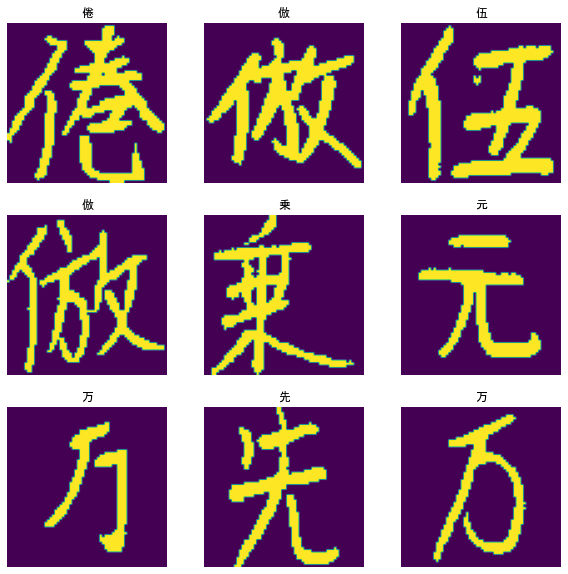

In [16]:
lbl = enc.inverse_transform(y_train)
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X_train[i])
  plt.title(lbl[i])
  plt.axis("off")


In [17]:
X_train = X_train * 1
X_test = X_test * 1


In [18]:

history = model.fit(
    x=X_train,
    y=y_train,
    epochs=50,
    initial_epoch=0,
    validation_data=(X_test, y_test),
    #callbacks=callbacks_list,
    max_queue_size=400,
    use_multiprocessing=True,
    workers=1)

Epoch 1/50
1131/1131 [==============================] - 26s 20ms/step - loss: 5.3004 - accuracy: 0.0049 - val_loss: 5.2969 - val_accuracy: 0.0052
Epoch 2/50
1131/1131 [==============================] - 22s 19ms/step - loss: 5.2969 - accuracy: 0.0052 - val_loss: 5.2969 - val_accuracy: 0.0052
Epoch 3/50
1131/1131 [==============================] - 22s 19ms/step - loss: 5.2969 - accuracy: 0.0055 - val_loss: 5.2969 - val_accuracy: 0.0052
Epoch 4/50
1131/1131 [==============================] - 22s 19ms/step - loss: 5.2969 - accuracy: 0.0050 - val_loss: 5.2969 - val_accuracy: 0.0035
Epoch 5/50
1131/1131 [==============================] - 22s 19ms/step - loss: 5.2969 - accuracy: 0.0058 - val_loss: 5.2969 - val_accuracy: 0.0030
Epoch 6/50
1131/1131 [==============================] - 22s 19ms/step - loss: 5.2969 - accuracy: 0.0052 - val_loss: 5.2969 - val_accuracy: 0.0030
Epoch 7/50
1131/1131 [==============================] - 22s 19ms/step - loss: 5.2969 - accuracy: 0.0049 - val_loss: 5.2969 -

KeyboardInterrupt: 

In [ ]:
model.summary()

In [ ]:


plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.0])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x=val_ds, verbose=2)

print(test_acc)

In [ ]:
model.save(os.path.join(model_dir, "tf", "trained_model"))

In [ ]:
image_batch, label_batch = next(iter(val_ds))
p = model.predict(image_batch)
p = p.argmax(axis=1)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(f'Actual: {class_names[label]}, Predicted: {class_names[p[i]]}')
    plt.axis("off")